<a href="https://colab.research.google.com/github/OleksiiLatypov/House_Prices/blob/main/notebook80180d881d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'house-prices-advanced-regression-techniques:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F5407%2F868283%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240901%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240901T202538Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D455a8f5d48d3d369c97ca20318fcac17e0bb6f0f1af2caeed84cb0b29c3090a3b5f8a998f7b2e7242df83f0017e17aff809123f341aa92f4fed978e8be7d2fed5120d8fd190ccad750f117c9899e0fcf757e0cf57b1676b98d2e1450e1911f37f991ffff5d91ca503244471493517eae6450b0ed0fbd993447f395b2a8dfbbab7941da549204028b7baa2159bd5710bd5f91bd9f1f3979a0bd33e01e71a285571693854324e154a396e2735a824a93ea54cfa924904341d0e4493a4647e9ab9736a3cc382d4068f4c4100822f065ac0b606775325a2d99d7abebd4e930e3efd3ba04ae0adcc1f5d91e019bff2d589e08eb4d24c60b8435f89c6d8f18e47961eb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline


In [ ]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [ ]:
num_columns = train.select_dtypes(include='number')
corr_matrix = num_columns.corr()
corr_with_target = corr_matrix['SalePrice']
strong_corr_with_target = corr_with_target[corr_with_target.abs() > 0.5].sort_values(ascending=False)
display(strong_corr_with_target)
highly_correlated = strong_corr_with_target.index.tolist()
highly_correlated

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd']

In [ ]:
num_columns = num_columns[highly_correlated]
num_columns.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
0,208500,7,1710,2,548,856,856,2,8,2003,2003
1,181500,6,1262,2,460,1262,1262,2,6,1976,1976
2,223500,7,1786,2,608,920,920,2,6,2001,2002
3,140000,7,1717,3,642,756,961,1,7,1915,1970
4,250000,8,2198,3,836,1145,1145,2,9,2000,2000


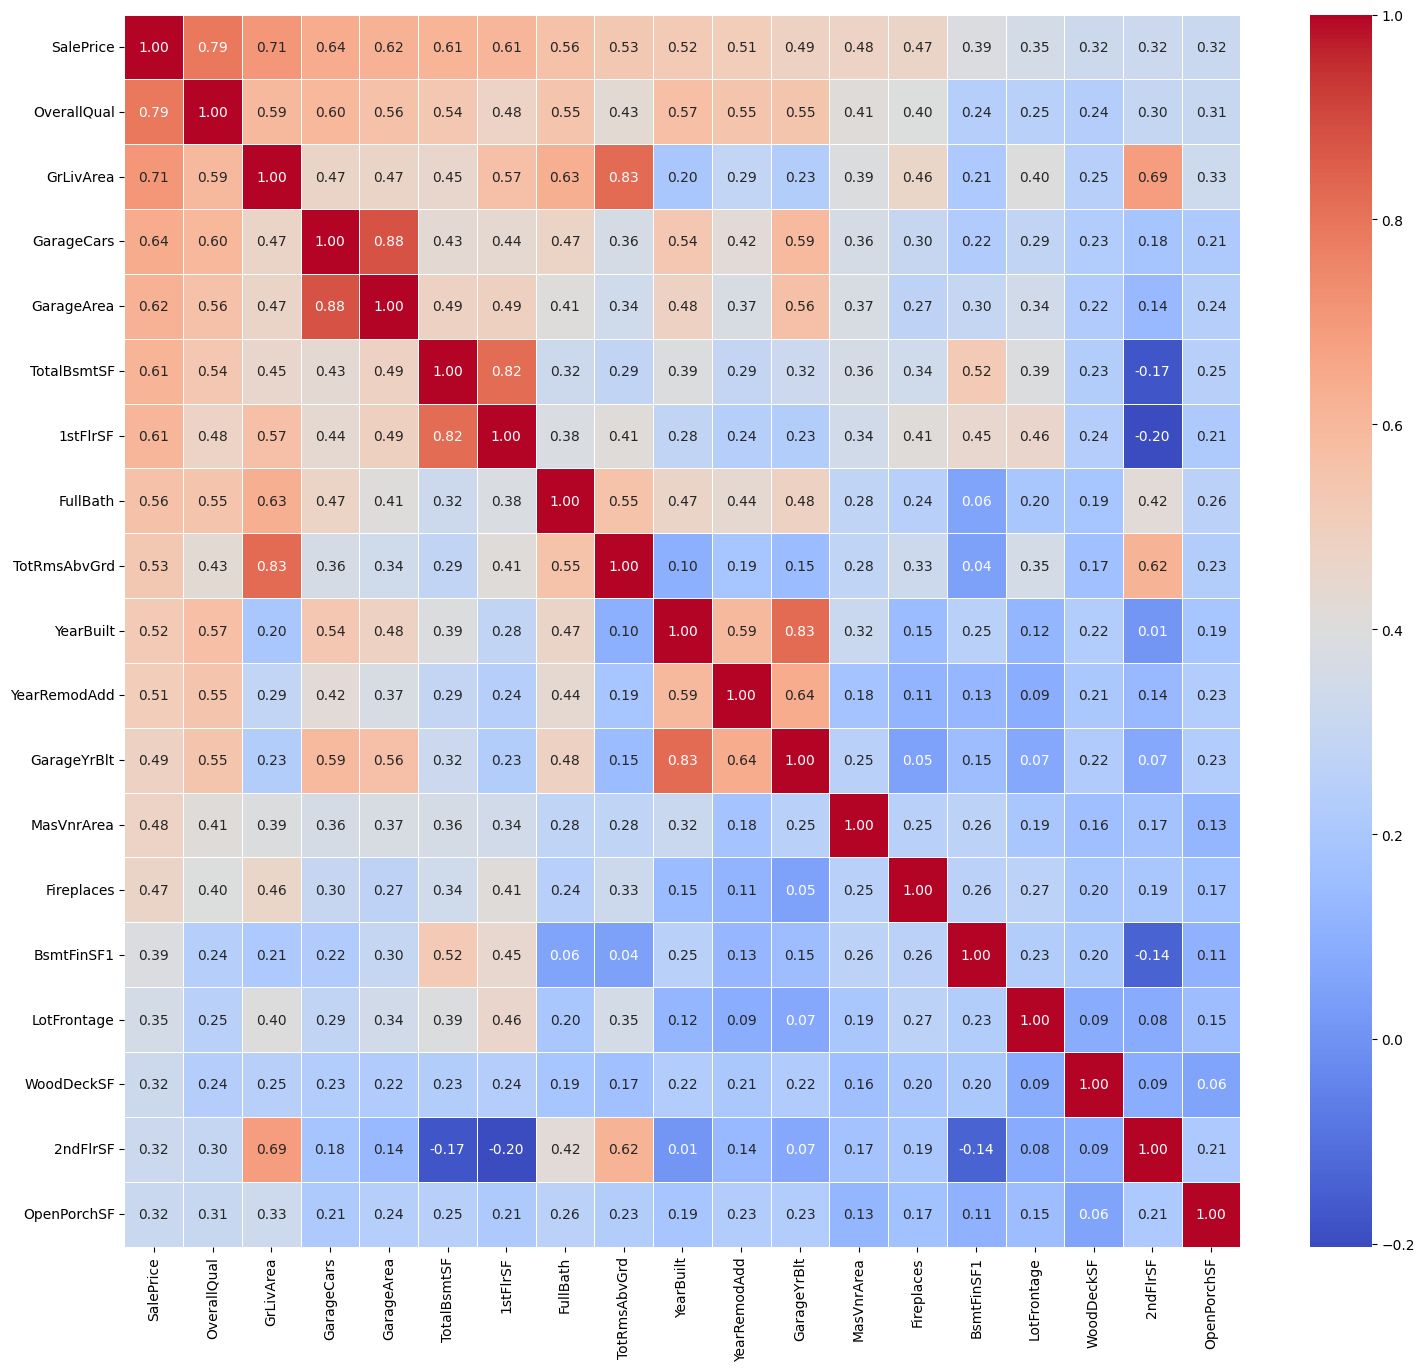

In [ ]:
plt.figure(figsize=(18, 16))
corr_num = num_columns.corr()
sns.heatmap(corr_num, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

In [ ]:
to_drop = ['1stFlrSF','GarageArea','TotRmsAbvGrd']#'GarageYrBlt'
num_columns = num_columns.drop(to_drop, axis=1)

In [ ]:
num_columns.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd
0,208500,7,1710,2,856,2,2003,2003
1,181500,6,1262,2,1262,2,1976,1976
2,223500,7,1786,2,920,2,2001,2002
3,140000,7,1717,3,756,1,1915,1970
4,250000,8,2198,3,1145,2,2000,2000


In [ ]:
df = pd.concat([train, test], axis=0, ignore_index=True)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [ ]:
df_cat = df.select_dtypes(include=['object'])
missing = 100 * (df_cat.isna().sum())/len(df_cat)
large_missing = [col for col in missing.index if missing[col] > 25]
large_missing

['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [ ]:
df = df.drop(large_missing, axis=1)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000.0


In [ ]:
df.isna().sum().sort_values(ascending=False)

SalePrice       1459
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageFinish     159
                ... 
HeatingQC          0
CentralAir         0
1stFlrSF           0
2ndFlrSF           0
Heating            0
Length: 75, dtype: int64

In [ ]:
df_cat_cols = df.select_dtypes('object')
for col in df_cat_cols.columns:
    df[col] = df[col].fillna(df[col].mode()[0])

In [ ]:
df_num_cols = df.select_dtypes('number')
for col in df_num_cols.columns:
    df[col] = df[col].fillna(df[col].mean())

In [ ]:
df.isna().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 75, dtype: int64

In [ ]:
categorical = df.select_dtypes('object')
print(categorical.shape)
numerical = df[highly_correlated]
print(numerical.shape)
X = pd.concat([numerical, categorical], axis=1)
X.shape

(2919, 37)
(2919, 11)


(2919, 48)

In [ ]:
X = pd.get_dummies(X, dtype='int')
X.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,208500.0,7,1710,2.0,548.0,856.0,856,2,8,2003,...,0,0,0,1,0,0,0,0,1,0
1,181500.0,6,1262,2.0,460.0,1262.0,1262,2,6,1976,...,0,0,0,1,0,0,0,0,1,0
2,223500.0,7,1786,2.0,608.0,920.0,920,2,6,2001,...,0,0,0,1,0,0,0,0,1,0
3,140000.0,7,1717,3.0,642.0,756.0,961,1,7,1915,...,0,0,0,1,1,0,0,0,0,0
4,250000.0,8,2198,3.0,836.0,1145.0,1145,2,9,2000,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
train_df = X.iloc[:1460, :]
train_df.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,208500.0,7,1710,2.0,548.0,856.0,856,2,8,2003,...,0,0,0,1,0,0,0,0,1,0
1,181500.0,6,1262,2.0,460.0,1262.0,1262,2,6,1976,...,0,0,0,1,0,0,0,0,1,0
2,223500.0,7,1786,2.0,608.0,920.0,920,2,6,2001,...,0,0,0,1,0,0,0,0,1,0
3,140000.0,7,1717,3.0,642.0,756.0,961,1,7,1915,...,0,0,0,1,1,0,0,0,0,0
4,250000.0,8,2198,3.0,836.0,1145.0,1145,2,9,2000,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
test_df = X.iloc[1460:, :]
test_df.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1460,180921.19589,5,896,1.0,730.0,882.0,896,1,5,1961,...,0,0,0,1,0,0,0,0,1,0
1461,180921.19589,6,1329,1.0,312.0,1329.0,1329,1,6,1958,...,0,0,0,1,0,0,0,0,1,0
1462,180921.19589,5,1629,2.0,482.0,928.0,928,2,6,1997,...,0,0,0,1,0,0,0,0,1,0
1463,180921.19589,6,1604,2.0,470.0,926.0,926,2,7,1998,...,0,0,0,1,0,0,0,0,1,0
1464,180921.19589,8,1280,2.0,506.0,1280.0,1280,2,5,1992,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
y = train_df['SalePrice']
train_df = train_df.drop('SalePrice', axis=1)

In [ ]:
train_df.shape

(1460, 240)

In [ ]:
train_df.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,7,1710,2.0,548.0,856.0,856,2,8,2003,2003,...,0,0,0,1,0,0,0,0,1,0
1,6,1262,2.0,460.0,1262.0,1262,2,6,1976,1976,...,0,0,0,1,0,0,0,0,1,0
2,7,1786,2.0,608.0,920.0,920,2,6,2001,2002,...,0,0,0,1,0,0,0,0,1,0
3,7,1717,3.0,642.0,756.0,961,1,7,1915,1970,...,0,0,0,1,1,0,0,0,0,0
4,8,2198,3.0,836.0,1145.0,1145,2,9,2000,2000,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor


clf_catboost = CatBoostRegressor(iterations=1500,#3800
#                                  learning_rate=0.02,
#                                  depth=4,
#                                  l2_leaf_reg=2,
                                  loss_function='RMSE',
#                                  border_count=42,
#                                  random_seed=0,
                                  verbose=0)  # verbose=0 to suppress output during cross-validation

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', clf_catboost)
])
# Define k-fold cross-validation
n_splits = 5  # number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform cross-validation and evaluate RMSE
rmse_scores = -cross_val_score(pipeline, train_data, y, scoring='neg_root_mean_squared_error', cv=kf)

# Calculate mean and standard deviation of RMSE
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Standard Deviation of RMSE: {std_rmse:.4f}")

pipeline.fit(train_data, y)

Mean RMSE: 28086.4351
Standard Deviation of RMSE: 7148.7316


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7daf8b907d30>)])

In [ ]:
test_df = test_df.drop(['SalePrice'], axis=1)

In [ ]:
test_df.shape

(1459, 248)

In [ ]:
test_id = test['Id']
test_predictions_catboost = pipeline.predict(test_df)
print(test_predictions_catboost)
# Prepare submission
test_predictions_catboost_df = pd.DataFrame((test_predictions_catboost), columns=['SalePrice'])
submit_df = pd.concat([test_id, test_predictions_catboost_df], axis=1)
submit_df.to_csv('submission.csv', index=False)

[117786.70079102 153939.58900312 180946.06828062 ... 160545.81022445
 121434.6482054  248371.56445241]


In [ ]:
check = pd.read_csv('/kaggle/working/submission.csv')
check


,Id,SalePrice
0,1461,117786.700791
1,1462,153939.589003
2,1463,180946.068281
3,1464,187833.690207
4,1465,195055.674687
...,...,...
1454,2915,78847.213403
1455,2916,83560.204581
1456,2917,160545.810224
1457,2918,121434.648205


In [ ]:
train_df.iloc[:10, :]

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,7,1710,2.0,548.0,856.0,856,2,8,2003,2003,...,0,0,0,1,0,0,0,0,1,0
1,6,1262,2.0,460.0,1262.0,1262,2,6,1976,1976,...,0,0,0,1,0,0,0,0,1,0
2,7,1786,2.0,608.0,920.0,920,2,6,2001,2002,...,0,0,0,1,0,0,0,0,1,0
3,7,1717,3.0,642.0,756.0,961,1,7,1915,1970,...,0,0,0,1,1,0,0,0,0,0
4,8,2198,3.0,836.0,1145.0,1145,2,9,2000,2000,...,0,0,0,1,0,0,0,0,1,0
5,5,1362,2.0,480.0,796.0,796,1,5,1993,1995,...,0,0,0,1,0,0,0,0,1,0
6,8,1694,2.0,636.0,1686.0,1694,2,7,2004,2005,...,0,0,0,1,0,0,0,0,1,0
7,7,2090,2.0,484.0,1107.0,1107,2,7,1973,1973,...,0,0,0,1,0,0,0,0,1,0
8,7,1774,2.0,468.0,952.0,1022,2,8,1931,1950,...,0,0,0,1,1,0,0,0,0,0
9,5,1077,1.0,205.0,991.0,1077,1,5,1939,1950,...,0,0,0,1,0,0,0,0,1,0
